In [1]:
%matplotlib inline
import torch
from torch import nn
import d2l_torch as d2l
import logging
import datetime
import importlib
import rnn_base
import os
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.optim as optim
import sys
import random
import numpy as np

import pandas as pd
import os
from gensim.models import word2vec
import torch
from torch.utils import data
from torch import nn
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

importlib.reload(rnn_base)


<module 'rnn_base' from 'C:\\Users\\rongjoker\\PycharmProjects\\ephemeralP\\pt\\rnn_base.py'>

In [2]:
batch_size = 128
home_dir = '../data/kaggle_toxic/input/'
path_prefix = "../data/kaggle_toxic/save/"

In [3]:
print('loading dataset imdb start: ', datetime.datetime.now())
# huge dataset
train_iter_1, test_iter_1, vocab = d2l.load_data_imdb(batch_size)
print('loading dataset imdb end:', datetime.datetime.now())

loading dataset imdb start:  2023-11-07 23:46:54.558866
loading dataset imdb end: 2023-11-07 23:51:00.286552


In [4]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
max_features = 20000

In [5]:

for dirname, _, filenames in os.walk(home_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/kaggle_toxic/input/sample_submission.csv.zip
../data/kaggle_toxic/input/test.csv.zip
../data/kaggle_toxic/input/test_labels.csv.zip
../data/kaggle_toxic/input/train.csv.zip


In [6]:
df_train = pd.read_csv(os.path.join(home_dir,'train.csv.zip'),error_bad_lines=False)

In [7]:
df_train.iloc[0:4]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0


In [8]:
len(df_train)

159571

In [9]:
df_test = pd.read_csv(os.path.join(home_dir,'test.csv.zip'),error_bad_lines=False)

In [10]:
df_test.iloc[0:4]

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."


In [11]:
len(df_test)

153164

In [12]:
df_test_labels = pd.read_csv(os.path.join(home_dir,'test_labels.csv.zip'),error_bad_lines=False)

In [13]:
df_test_labels.iloc[0:4]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1


In [14]:
len(df_test_labels)

153164

In [15]:
sample_submission = pd.read_csv(os.path.join(home_dir,'sample_submission.csv.zip'),error_bad_lines=False)

In [16]:
sample_submission.iloc[0:4]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5


In [17]:
y = df_train[list_classes].values
list_sentences_train = df_train["comment_text"]
list_sentences_test = df_test["comment_text"]

In [18]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [19]:
def load_data_imdb(batch_size, num_steps=500):
    df_labeledTrainData = pd.read_csv(os.path.join(home_dir,'train.csv.zip'),error_bad_lines=False)
    train_x, train_y = list(df_labeledTrainData['comment_text']), list(df_labeledTrainData[list_classes].values)
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    n_train = len(df_labeledTrainData)
    train_slices = random.sample(list(range(n_train)), int(round(n_train * 0.9, 0)))
    test_slices = list(set(range(n_train)) - set(train_slices))
    
    train_data = (train_x[train_slices], list(train_y[train_slices]))
    test_data = (train_x[test_slices], list(train_y[test_slices]))
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1], dtype=torch.float)),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1], dtype=torch.float)),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter

In [20]:
def load_data_imdb_infer(batch_size, num_steps=500):
    df_test = pd.read_csv(os.path.join(home_dir,'test.csv.zip'),error_bad_lines=False)
    infer_x = list(df_test['comment_text'])

    infer_tokens = d2l.tokenize(infer_x, token='word')
    infer_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in infer_tokens])
    infer_iter = d2l.load_array((infer_features,infer_features),
                               batch_size,
                               is_train=False)
    return infer_iter

In [34]:
def train_figure(net, glove_embedding, train_iter, test_iter, num_epochs, lr, num_gpus):
    def init_weights(module):
        if type(module) == nn.Linear:
            nn.init.xavier_uniform_(module.weight)
        if type(module) == nn.LSTM:
            for param in module._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(module._parameters[param])

    def accuracy(y_hat, y):
        category=y_hat
        # print('----')
        # print(category.shape)
        for j in range(y_hat.shape[0]):
            # print(category[j])
            temp = [0 if item<=0.5 else 1 for item in y_hat[j] ]
            # print(temp)
            # print(y.cpu())
        # return (y_hat.argmax(1) == y).sum()
        return 128
    
    def animation(animator, epoch_index):
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        test_loss = test_loss_tot / test_tot
        animator.add(epoch_index, (train_loss.cpu(), test_loss.cpu(), train_acc, test_acc))
        

    print(net)
    model_path = os.path.join(path_prefix, 'toxic_lstm_%s.pth' % num_epochs)
    result_csv_path = os.path.join(path_prefix, 'train_detail_%s.csv' % num_epochs)
    print('model_path:', model_path)
    print('result_csv_path:', result_csv_path)
    net.apply(init_weights)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    print(devices)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    #     trainer = torch.optim.SGD(net.parameters(), lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # loss = nn.CrossEntropyLoss()
    loss = nn.BCELoss()
    train_detail = pd.DataFrame(columns=['train_loss', 'test_loss', 'train acc', 'test acc'])
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train_loss', 'test_loss', 'train acc', 'test acc'])
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        train_loss_tot, train_acc_tot, train_tot = 0, 0, 0
        test_loss_tot, test_acc_tot, test_tot = 0, 0, 0
        net.train()
        # for X, y in train_iter:
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            # print(y)
            # print('-----')
            # print(y_hat)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                cur_loss = l * X.shape[0]
                train_loss_tot += cur_loss
                cur_acc = accuracy(y_hat, y)
                train_acc_tot += cur_acc
                train_tot += X.shape[0]
                if (i + 1) % (num_batches // 10) == 0 or i == (num_batches - 1):
                    animator.add(epoch + (i + 1) / num_batches,
                                 ((cur_loss / X.shape[0]).cpu(), None,cur_acc / X.shape[0],
                                  None))
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(devices[0]), y.to(devices[0])
                y_hat = net(X)
                test_loss_tot += l * X.shape[0]
                test_acc_tot += accuracy(y_hat, y)
                test_tot += X.shape[0]
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        test_loss = test_loss_tot / test_tot
        animator.add(epoch + 1, (train_loss.cpu(), test_loss.cpu(), train_acc, test_acc))
        train_detail.loc[len(train_detail)] = [train_loss.cpu(), test_loss.cpu(), train_acc, test_acc]
        # print('train_loss:', train_loss, '\ttrain_acc', test_acc, '\ttest_acc', test_acc)
        torch.save(net.state_dict(), model_path)
        train_detail.to_csv(result_csv_path, index=False)

In [22]:
batch_size = 128
# tiny dataset
train_iter, test_iter = load_data_imdb(batch_size)

C:\Users\rongjoker\AppData\Local\Temp\ipykernel_48100\1972909296.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  train_iter = d2l.load_array((train_features, torch.tensor(train_data[1], dtype=torch.float)),


In [23]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [24]:
for i,(x,y) in enumerate(train_iter):
    # print(y)
    # print(y.to(torch.int64))
    break

In [25]:
_infer_iter = load_data_imdb_infer(batch_size)

In [26]:
len(_infer_iter)

1197

In [27]:
for i,y in enumerate(_infer_iter):
    print(y)
    break

[tensor([[17176, 20126,  3680,  ...,  3680,  3680,  3680],
        [ 3680,  8279,  3680,  ...,  3680,  3680,  3680],
        [   12,  3680,  3680,  ...,  3680,  3680,  3680],
        ...,
        [   12,  3680, 31579,  ...,  3680,  3680,  3680],
        [46105,  3680, 49241,  ...,  3680,  3680,  3680],
        [ 3680,  3680,  3680,  ...,  3680,  3680,  3680]]), tensor([[17176, 20126,  3680,  ...,  3680,  3680,  3680],
        [ 3680,  8279,  3680,  ...,  3680,  3680,  3680],
        [   12,  3680,  3680,  ...,  3680,  3680,  3680],
        ...,
        [   12,  3680, 31579,  ...,  3680,  3680,  3680],
        [46105,  3680, 49241,  ...,  3680,  3680,  3680],
        [ 3680,  3680,  3680,  ...,  3680,  3680,  3680]])]


In [28]:
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # 製作 embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # 是否將 embedding fix住，如果fix_embedding為False，在訓練過程中，embedding也會跟著被訓練
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 6),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # x 的 dimension (batch, seq_len, hidden_size)
        # 取用 LSTM 最後一層的 hidden state
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

In [29]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 6)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        print(outputs.shape)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        print(encoding.shape)
        outs = self.decoder(encoding)
        return outs

In [30]:
class Bi_LSTM_Net(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(Bi_LSTM_Net, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        # self.decoder = nn.Linear(4 * num_hiddens, 2)
        self.decoder = nn.Sequential( nn.Dropout(0.5),
                                         nn.Linear(4 * num_hiddens, 6),
                                         nn.Sigmoid() )

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        # print(outputs.shape)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # print(encoding.shape)
        outs = self.decoder(encoding)
        return outs

KeyboardInterrupt: 

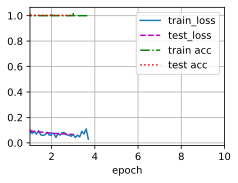

In [35]:
EPOCHS = 10
LR = 0.001

# rnn_train(glove_embedding, train_iter, test_iter, vocab, LR, EPOCHS)
# net = LSTM_Net(glove_embedding, embedding_dim=250, hidden_dim=250, num_layers=2, dropout=0.5, fix_embedding=True)
embed_size, num_hiddens, num_layers = 100, 100, 2
net = Bi_LSTM_Net(len(vocab), embed_size, num_hiddens, num_layers)
# net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
train_figure(net, glove_embedding, train_iter, test_iter, EPOCHS, LR, 1)

In [ ]:
def testing(test_loader, epochs, num_gpus):
    model_path = os.path.join(path_prefix, 'toxic_lstm_%s.pth' % epochs)
    print(model_path)
    embed_size, num_hiddens, num_layers = 100, 100, 2
    model = Bi_LSTM_Net(len(vocab), embed_size, num_hiddens, num_layers)
    # 直接运行，acc 0.5
    # model.load_state_dict(torch.load(model_path), False)
    # 多卡 ，acc 0.9
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    model = nn.DataParallel(model, device_ids=devices).to(devices[0])
    model.load_state_dict(torch.load(model_path))
    
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    ret_output = []
    with torch.no_grad():
        for i, (inputs,_inputs) in enumerate(test_loader):
            inputs = inputs.to(d2l.try_gpu())
            outputs = model(inputs)
            outputs = outputs.squeeze()
            ret_output += outputs.tolist()
    
    return ret_output

In [ ]:
ret_output = testing(_infer_iter, 10, 1)
df_pred = pd.read_csv(os.path.join(home_dir,'test.csv.zip'),error_bad_lines=False)
submid = pd.DataFrame({'id': df_pred['id']})
pred=pd.DataFrame(ret_output,columns = list_classes)
# 寫到csv檔案供上傳kaggle
submission = pd.concat([submid,pred], axis=1)
submission.to_csv(os.path.join(path_prefix, 'submission_lstm.csv'), index = False)
print("Finish Predicting")